# Plot Visitation Distributions

#### Primary Author
Chris Carey

#### Description:
This notebook plots the distribution of food location visitations for various categories among various groupings of census block groups (CBGs).

#### Inputs:
```
data/cbg_attr_and_cluster_1021.csv
exports/home_weekly.csv
exports/poi_health_recategorized.csv
```

#### Visualizations:
> Stacked time-series plots of % of food location visitations by POI category\
> Stacked time-series plots of % of food location visitations by POI category across income percentiles\
> Scatter plots of % of food location visitations by POI category across income percentiles\

In [1]:
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pytz

import warnings
warnings.filterwarnings('ignore')

In [2]:
def peek(df):
    display(df.iloc[0:3, :])
    print(len(df))

In [3]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [4]:
def smoothen(df, columns=[], N=2):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns."""
    rolling_groupby = df.copy().reset_index(level=1).groupby(by=['cluster'])
    rolling_df = rolling_groupby[columns].rolling(N + 1, center=True).mean()
    rolling_df = rolling_df.reset_index()
    rolling_df = rolling_df.sort_values(by=['date_range_start', 'cluster'])
    rolling_df = rolling_df.set_index(['date_range_start', 'cluster'])
    return rolling_df

def smoothen_within(df, columns=[], by=None, N=6):
    """Returns a copy of the given dataframe with a rolling-day average of the
    given size applied to the given columns within each attribute class
    determined by the given "by" attribute."""
    attr_classes = set(df[by])
    rolling_dfs = []
    for attr_class in attr_classes:
        attr_class_df = df[df[by] == attr_class]
        rolling_dfs.append(smoothen(attr_class_df, columns, N=N))
    rolling_df = pd.concat(rolling_dfs)
    rolling_df = rolling_df.sort_values(by=['date_range_start', by])
    return rolling_df

## Segment Supermarkets and Grocery Stores by CBG Income

In [5]:
poi_df = pd.read_csv(f'./exports/poi_health_recategorized.csv')
peek(poi_df)

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude
0,222-222@627-s94-nwk,360470395002,445210,Specialty Food Stores,Meat Markets,Broadway Meats,3177.0,40.691436,-73.924891
1,223-222@627-rw6-zfz,360050386008,445110,Supermarkets,Supermarkets and Other Grocery (except Conveni...,Foodtown,3401.0,40.876890,-73.847776
2,223-222@627-rwq-vcq,360050117001,445110,Supermarkets,Supermarkets and Other Grocery (except Conveni...,Kirsch Mushroom Company,10079.0,40.816779,-73.883401


36475


In [6]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Median Household Income': 'income',
    'Total Population': 'population',
})
cbg_df = cbg_df[['cbg', 'income', 'population']]
peek(cbg_df)

,cbg,income,population
0,360050001001,NaN,6864
1,360050002001,41968.0,1744
2,360050002002,48523.0,1569


6221


In [7]:
def add_percentiles(df, column):
    cdf = df.copy()
    percents = list(range(10, 110, 10))
    values = [np.percentile(cdf[column].dropna(), p) for p in percents]
    
    cdf[f'{column}_percentile'] = None
    for i, value in enumerate(values):
        cdf.loc[(cdf[f'{column}_percentile'].isna()) & (cdf[column] <= value), f'{column}_percentile'] = percents[i] 
    return cdf

In [8]:
sgs_df = poi_df.merge(cbg_df, on='cbg', how='inner')
sgs_df = sgs_df[sgs_df['category'] == 'Delis and Convenience Stores']
sgs_df = add_percentiles(sgs_df, 'income')
sgs_df = add_percentiles(sgs_df, 'area_square_feet')
peek(sgs_df)

,placekey,cbg,naics_code,category,sub_category,location_name,area_square_feet,latitude,longitude,income,population,income_percentile,area_square_feet_percentile
36,22n-222@627-rw6-mff,360050378003,445120,Delis and Convenience Stores,Delis and Convenience Stores,Tito's Mini Market,852.0,40.878042,-73.866717,30795.0,597,10,10
93,229-222@627-s64-tgk,360050283002,722511,Delis and Convenience Stores,Delis and Convenience Stores,Gourmet Deli,5388.0,40.884902,-73.900444,52052.0,1286,30,80
110,22n-222@627-s93-66k,360470493002,722511,Delis and Convenience Stores,Delis and Convenience Stores,The Lunch Box Deli &amp Grill,NaN,40.708839,-73.940228,76637.0,1191,60,None


1877


In [9]:
sgs_count_df = sgs_df.groupby(by=['income_percentile', 'area_square_feet_percentile']).agg({'placekey': 'count'}).reset_index()
sgs_count_df = sgs_count_df.rename(columns={'placekey': 'count'})
peek(sgs_count_df)

,income_percentile,area_square_feet_percentile,count
0,10,10,16
1,10,20,6
2,10,30,18


100


In [10]:
home_weekly_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_weekly_df)
home_weekly_df = home_weekly_df[home_weekly_df['date_range_start'].dt.year.isin([2019, 2020])]
home_weekly_df = home_weekly_df.rename(columns={'home_cbg': 'cbg'})
peek(home_weekly_df)

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
77,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050001001,4,203.377778,0.500000,0.500000,155.884113
78,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050043001,4,6.694275,0.015094,0.015094,5.130999
79,zzy-229@627-s7k-snq,2019-01-07 00:00:00-05:00,360050051002,4,4.703779,0.005548,0.005548,3.605332


26592552


In [11]:
sgs_weekly_df = sgs_df.merge(home_weekly_df, on='placekey', how='inner')
sgs_weekly_df = sgs_weekly_df.rename(columns={
    'cbg_x': 'poi_cbg',
    'cbg_y': 'home_cbg',
    'income': 'poi_income',
    'income_percentile': 'poi_income_percentile',
})
sgs_weekly_df = sgs_weekly_df[[
    'placekey',
    'date_range_start',
    'estimated_visitor_count',
    'area_square_feet_percentile',
    'poi_cbg',
    'poi_income',
    'poi_income_percentile',
    'home_cbg',
]]
peek(sgs_weekly_df)

,placekey,date_range_start,estimated_visitor_count,area_square_feet_percentile,poi_cbg,poi_income,poi_income_percentile,home_cbg
0,22n-222@627-rw6-mff,2019-09-02 00:00:00-04:00,9.001290,10,360050378003,30795.0,10,360050075002
1,22n-222@627-rw6-mff,2019-09-09 00:00:00-04:00,7.158969,10,360050378003,30795.0,10,360050378001
2,22n-222@627-rw6-mff,2020-04-13 00:00:00-04:00,13.100737,10,360050378003,30795.0,10,360050378001


1052700


In [12]:
sgs_income_df = sgs_weekly_df.merge(cbg_df, left_on='home_cbg', right_on='cbg')
sgs_income_df = add_percentiles(sgs_income_df, 'income')
sgs_income_df = sgs_income_df.rename(columns={
    'income': 'home_income',
    'income_percentile': 'home_income_percentile',
})
sgs_income_df = sgs_income_df[[
    'placekey',
    'date_range_start',
    'estimated_visitor_count',
    'area_square_feet_percentile',
    'poi_cbg',
    'poi_income',
    'poi_income_percentile',
    'home_cbg',
    'home_income',
    'home_income_percentile',
]]
peek(sgs_income_df)

,placekey,date_range_start,estimated_visitor_count,area_square_feet_percentile,poi_cbg,poi_income,poi_income_percentile,home_cbg,home_income,home_income_percentile
0,22n-222@627-rw6-mff,2019-09-02 00:00:00-04:00,9.001290,10,360050378003,30795.0,10,360050075002,32037.0,20
1,229-222@627-s64-tgk,2019-07-08 00:00:00-04:00,9.709116,80,360050283002,52052.0,30,360050075002,32037.0,20
2,22g-222@627-wdk-b49,2019-05-27 00:00:00-04:00,9.172913,100,360470594021,76827.0,60,360050075002,32037.0,20


1052700


In [13]:
sgs_income_df['income_direction'] = np.where(sgs_income_df['home_income'] > sgs_income_df['poi_income'], 1, 0)
sgs_income_df['year'] = sgs_income_df['date_range_start'].dt.year
sgs_income_df['month'] = sgs_income_df['date_range_start'].dt.month
sgs_income_df = sgs_income_df[(sgs_income_df['month'] >= 2) & (sgs_income_df['month'] <=5)]
peek(sgs_income_df)

,placekey,date_range_start,estimated_visitor_count,area_square_feet_percentile,poi_cbg,poi_income,poi_income_percentile,home_cbg,home_income,home_income_percentile,income_direction,year,month
2,22g-222@627-wdk-b49,2019-05-27 00:00:00-04:00,9.172913,100,360470594021,76827.0,60,360050075002,32037.0,20,0,2019,5
5,22c-222@627-s6d-5cq,2019-05-06 00:00:00-04:00,8.903638,90,360610241004,70583.0,50,360050075002,32037.0,20,0,2019,5
7,237-222@627-s96-y35,2019-04-29 00:00:00-04:00,8.714553,None,360470553001,113704.0,90,360050075002,32037.0,20,0,2019,4


355498


In [14]:
poi_weekly_df = pd.read_csv('./exports/poi_weekly.csv')
poi_weekly_df = poi_weekly_df[['placekey', 'date_range_start', 'median_dwell', 'contact_density']]
repair_dates(poi_weekly_df)
peek(poi_weekly_df)

,placekey,date_range_start,median_dwell,contact_density
0,22b-222@627-rwr-4n5,2018-12-31 00:00:00-05:00,26.0,0.039394
1,22b-222@627-rwr-4n5,2019-01-07 00:00:00-05:00,22.0,0.026984
2,22b-222@627-rwr-4n5,2019-01-14 00:00:00-05:00,22.0,0.019014


3693204


In [15]:
sgs_dwell_df = sgs_income_df.merge(poi_weekly_df, on=['placekey', 'date_range_start'], how='inner')

In [16]:
sgs_id_df = sgs_dwell_df.groupby(by=['year', 'poi_income_percentile', 'area_square_feet_percentile']).agg({'estimated_visitor_count': 'sum', 'median_dwell': 'mean', 'contact_density': 'median'}).reset_index()
peek(sgs_id_df)

,year,poi_income_percentile,area_square_feet_percentile,estimated_visitor_count,median_dwell,contact_density
0,2019,10,10,19857.731547,28.783558,0.150311
1,2019,10,20,7101.562829,24.718155,0.067157
2,2019,10,30,23313.691799,53.763370,0.083333


200


In [17]:
from sklearn.preprocessing import StandardScaler
sgs_id_df[['std_estimated_visitor_count']] = StandardScaler().fit_transform(sgs_id_df[['estimated_visitor_count']]) * 40 + 20
peek(sgs_id_df)

,year,poi_income_percentile,area_square_feet_percentile,estimated_visitor_count,median_dwell,contact_density,std_estimated_visitor_count
0,2019,10,10,19857.731547,28.783558,0.150311,37.391826
1,2019,10,20,7101.562829,24.718155,0.067157,-17.399783
2,2019,10,30,23313.691799,53.763370,0.083333,52.236222


200


<AxesSubplot:xlabel='poi_income_percentile', ylabel='area_square_feet_percentile'>

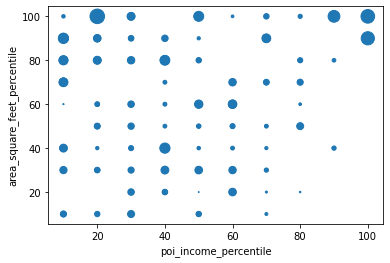

In [18]:
sgs_id_df.plot(kind='scatter', x='poi_income_percentile', y='area_square_feet_percentile', s='std_estimated_visitor_count')

<AxesSubplot:xlabel='poi_income_percentile', ylabel='area_square_feet_percentile'>

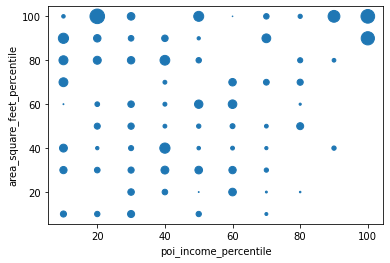

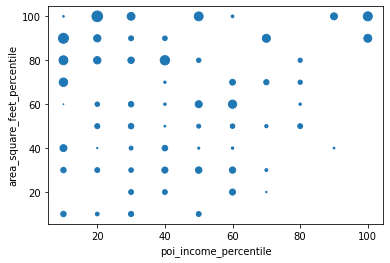

In [19]:
p_2019_df = sgs_id_df[sgs_id_df['year'] == 2019]
p_2019_df.plot(kind='scatter', x='poi_income_percentile', y='area_square_feet_percentile', s='std_estimated_visitor_count')
p_2020_df = sgs_id_df[sgs_id_df['year'] == 2020]
p_2020_df.plot(kind='scatter', x='poi_income_percentile', y='area_square_feet_percentile', s='std_estimated_visitor_count')

<AxesSubplot:xlabel='area_square_feet_percentile', ylabel='contact_density'>

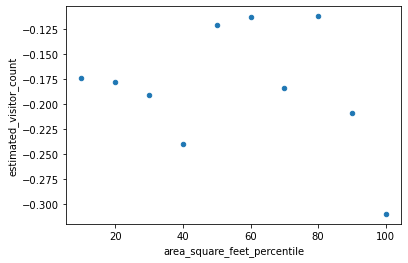

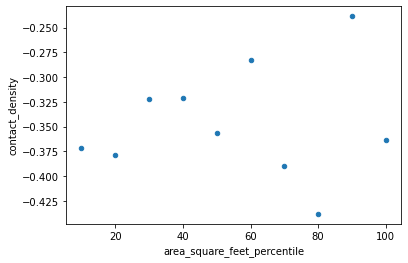

In [20]:
p_2019_df = sgs_id_df[sgs_id_df['year'] == 2019].groupby(by=['area_square_feet_percentile']).agg({'estimated_visitor_count': 'sum', 'contact_density': 'median'}).reset_index()
p_2020_df = sgs_id_df[sgs_id_df['year'] == 2020].groupby(by=['area_square_feet_percentile']).agg({'estimated_visitor_count': 'sum', 'contact_density': 'median'}).reset_index()
pdf = p_2020_df.copy()
pdf['estimated_visitor_count'] = (p_2020_df['estimated_visitor_count'] - p_2019_df['estimated_visitor_count']) / p_2019_df['estimated_visitor_count']
pdf['contact_density'] = (p_2020_df['contact_density'] - p_2019_df['contact_density']) / p_2019_df['contact_density']
pdf.plot(kind='scatter', x='area_square_feet_percentile', y='estimated_visitor_count')
pdf.plot(kind='scatter', x='area_square_feet_percentile', y='contact_density')